In [1]:
from astropy.table import Table, column, vstack
import astropy.units as u
import numpy as np

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### Load the relevant data

In [2]:
# SDSS + GZ2
sdss_halo_table = Table.read('fits/sdss_halo_table_matched.fits')
sdss_w_gas_table = Table.read('fits/sdss_w_gas_table_matched.fits')
masks = Table.read('fits/masks.fits')

# S4G
s4g_halo_table = Table.read('fits/s4g_halo_table_matched.fits')

# masking
in_s4g = s4g_halo_table['unbarred_sample']
in_sdss = masks['z<0.085 (unbarred spiral)']
in_sdss_hi = masks['z<0.085 (+HI unbarred spiral)']

#### Create the four haloes:

* MW (Bovy+rix)
* 'Typical' (ie. median) S4G galaxy
* Typical SDSS galaxy
* Typial SDSS galaxy with a gas component

In [3]:
import imp
import halo_v2
imp.reload(halo_v2)
from halo_v2 import TotalHalo

### Milky Way for reference #######

m_b_mw = [4e9] * u.Msun
delta_m_b_mw = [0] * u.Msun

m_d_mw = [5.3e10] * u.Msun
delta_m_d_mw = [0.5e10] * u.Msun

a_b_mw = [0.6] * u.kpc
delta_a_b_mw = [0] * u.kpc

R_d_mw = [2.15] * u.kpc
delta_R_d_mw = [0.14] * u.kpc

m_hi_mw = [0] * u.Msun
delta_m_hi_mw = [0] * u.Msun

m_halo_mw = [9.5e11] * u.Msun
delta_m_halo_mw = [0.2] * m_halo_mw

R_halo_mw = [29.6] * u.kpc
delta_R_halo_mw = [0.2] * R_halo_mw
######################################

mw_halo = TotalHalo(m_b_mw,delta_m_b_mw,m_d_mw,delta_m_d_mw,
                    a_b_mw,delta_a_b_mw,R_d_mw,delta_R_d_mw,
                    m_hi_mw,delta_m_hi_mw)

d15_halo = TotalHalo(m_b_mw,delta_m_b_mw,m_d_mw,delta_m_d_mw,
                     a_b_mw,delta_a_b_mw,R_d_mw,delta_R_d_mw,
                     m_hi_mw,delta_m_hi_mw,
                     m_halo_mw,delta_m_halo_mw,
                     R_halo_mw,delta_R_halo_mw,fix_halo=True)

m_h_mw = [mw_halo.M_halo()[0].nominal_value] * u.Msun
delta_m_h_mw = [mw_halo.M_halo()[0].std_dev] * u.Msun

R_h_mw = [mw_halo.R_halo()[0][0].nominal_value] * u.kpc
delta_R_h_mw = [mw_halo.R_halo()[0][0].std_dev] * u.kpc

mw_halo_values = (m_d_mw, delta_m_d_mw, R_d_mw, delta_R_d_mw, 
                  m_b_mw, delta_m_b_mw, a_b_mw, delta_a_b_mw, 
                  m_h_mw, delta_m_h_mw, R_h_mw, delta_R_h_mw)

In [4]:
def get_median_halo(data,mask):
    
    colnames = ['M_disc','delta_M_disc',
                'R_disc','delta_R_disc',
                'M_bulge','delta_M_bulge',
                'R_bulge','delta_R_bulge',
                'M_halo','delta_M_halo',
                'R_halo','delta_R_halo']
    
    col_units = (u.Msun,u.Msun,u.kpc,u.kpc,u.Msun,u.Msun,u.kpc,u.kpc,
                 u.Msun,u.Msun,u.kpc,u.kpc)
    
    median_values = []
    
    for column, unit_ in zip(colnames,col_units):
        d_column = data[column][mask]
        median_value = np.median(np.array(d_column))
        median_value = [median_value] * unit_
        median_values.append(median_value)
        
    (m_d, delta_m_d, R_d, delta_R_d, 
     m_b, delta_m_b, a_b, delta_a_b, 
     m_h, delta_m_h, R_h, delta_R_h) = median_values
    
    median_halo = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,a_b,
                            delta_a_b,R_d,delta_R_d,0*u.Msun,0*u.Msun,
                            m_h,delta_m_h,R_h,delta_R_h)
    
    return median_halo, median_values

s4g_halo, s4g_values = get_median_halo(s4g_halo_table,in_s4g)
sdss_halo, sdss_values = get_median_halo(sdss_halo_table,in_sdss)
sdss_w_gas, sdss_w_gas_values = get_median_halo(sdss_w_gas_table,in_sdss)

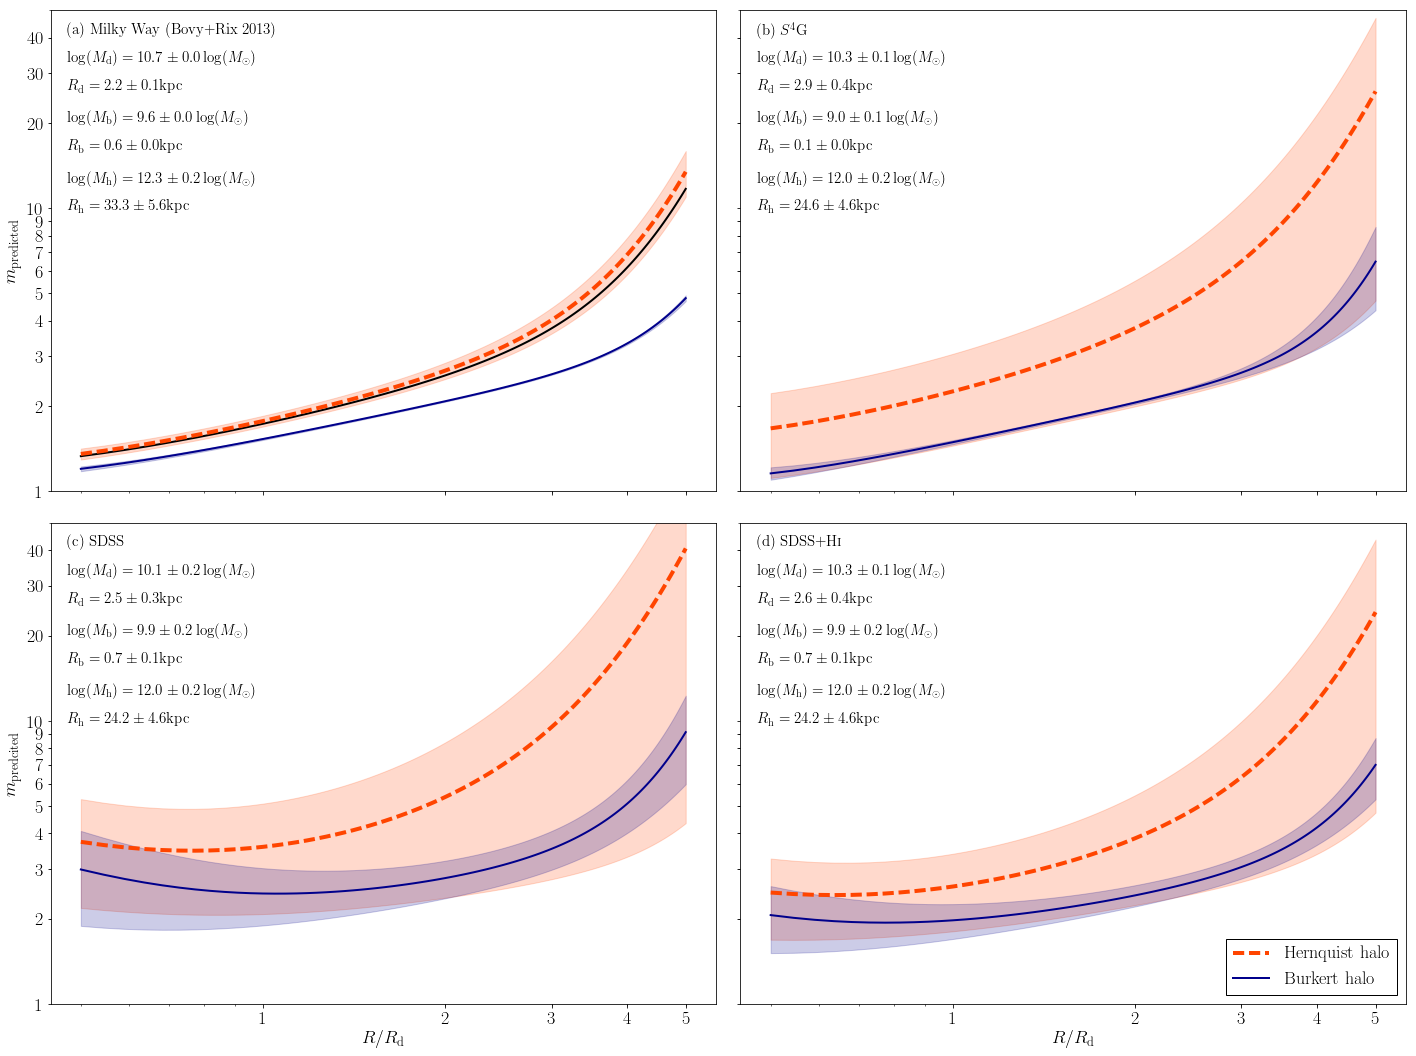

In [5]:
fig, axarr = plt.subplots(2,2,figsize=(20,15),sharex=True,sharey=True)
axarr = axarr.ravel()
ax = axarr[0]

y = np.linspace(0.25,2.5,100)

m_donghia = (d15_halo.bulge_arm_number(y) 
           + d15_halo.disc_arm_number(y)
           + d15_halo.hernquist_arm_number(y))

m_donghia = [m.nominal_value for m in m_donghia]

_ = ax.plot(y*2,m_donghia,
            lw=2,color='k',label="D'Onghia+15",zorder=1)

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xticks([1,2,3,4,5])
_ = ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
_ = ax.set_yticks([1,2,3,4,5,6,7,8,9,10,20,30,40])
_ = ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


halo_list = [mw_halo,s4g_halo,sdss_halo,sdss_w_gas]
halo_value_list = [mw_halo_values,s4g_values,sdss_values,sdss_w_gas_values]
letters = 'abcdefghijklmnopqrstuvwxyz'
labels = (r'Milky Way (Bovy+Rix 2013)',r'$S^4$G',r'SDSS',r'SDSS+H\textsc{i}')

def mass_string(value,error,subscript='b'):
    
    v = np.round(np.log10(value.value[0]),decimals=1)
    delta_v =np.round(0.434 * (error.value[0]/value.value[0]),decimals=1)
    s = r'$\log(M_\mathrm{{{}}}) = {} \pm {} \log(M_\mathrm{{\odot}})$'.format(
                                                       subscript, v,delta_v)
    return s

def radius_string(value,error,subscript='b'):
    v = np.round(value.value[0],decimals=1)
    delta_v = np.round(error.value[0],decimals=1)
    s = r'$R_\mathrm{{{}}}= {} \pm {} \mathrm{{kpc}}$'.format(
                                          subscript,v,delta_v)
    return s
       
for ax, halo_, halo_values, letter, label in zip(
    axarr,halo_list,halo_value_list,letters,labels):

    m_hernquist = (halo_.bulge_arm_number(y) 
                 + halo_.disc_arm_number(y)
                 + halo_.hernquist_arm_number(y))
    
    m_burkert = (halo_.bulge_arm_number(y) 
               + halo_.disc_arm_number(y)
               + halo_.burkert_arm_number(y))
    
    m_hernquist_ = np.array([m.nominal_value for m in m_hernquist])
    m_burkert_ = np.array([m.nominal_value for m in m_burkert])
    m_h_error = np.array([m.std_dev for m in m_hernquist])
    m_b_error = np.array([m.std_dev for m in m_burkert])
    
    (m_d, delta_m_d, R_d, delta_R_d, 
     m_b, delta_m_b, a_b, delta_a_b, 
     m_h, delta_m_h, R_h, delta_R_h) = halo_values
    
    strings = [r'({}) {}'.format(letter,label),
               mass_string(m_d,delta_m_d,'d'),
               radius_string(R_d,delta_R_d,'d'),
               mass_string(m_b,delta_m_b,'b'),
               radius_string(a_b,delta_a_b,'b'),
               mass_string(m_h,delta_m_h,'h'),
               radius_string(R_h,delta_R_h,'h')]
    
    y_pos = np.linspace(0.975,0.6,7)
    for s, y_ in zip(strings, y_pos):
        ax.text(0.025,y_,s,ha='left',va='top',transform=ax.transAxes,
                fontsize=15)
    
    _ = ax.plot(2*y,m_hernquist_,lw=4,linestyle='dashed',color='orangered',
                label='Hernquist halo')
    _ = ax.fill_between(2*y,m_hernquist_-m_h_error,m_hernquist_+m_h_error,
                        color='orangered',alpha=0.2,label='_nolegend_')
    
    _ = ax.plot(2*y,m_burkert_,lw=2,linestyle='solid',color='darkblue',
                label='Burkert halo')
    _ = ax.fill_between(2*y,m_burkert_-m_b_error,m_burkert_+m_b_error,
                        color='darkblue',alpha=0.2,label='_nolegend_')
    _ = ax.set_ylim(1,50)
    
_ = axarr[0].set_ylabel('$m_\mathrm{predicted}$')
_ = axarr[2].set_ylabel('$m_\mathrm{predcited}$')
_ = axarr[2].set_xlabel('$R/R_\mathrm{d}$')
_ = axarr[3].set_xlabel('$R/R_\mathrm{d}$')
_ = axarr[1].plot([],[],color='k',lw=2,label="D'Onghia+15")
_ = axarr[-1].legend(loc='lower right',edgecolor='k',fancybox=False,
                    framealpha=1)
fig.tight_layout()

fig.savefig('figures/typical_galaxies.pdf')